## Set Up and Clean Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import helpers as hp
import models.randomforest as rf
import models.lstm as lstm


In [2]:
# recent https://forecast.weather.gov/product.php?site=MFL&issuedby=MIA&product=CLI&format=CI&version=2&glossary=0
# Old https://climatecenter.fsu.edu/climate-data-access-tools/downloadable-data


df = pd.read_csv("Data/True values/miami_weather_complete.csv")
df['Datetime'] = pd.to_datetime(df['Datetime'])

In [3]:
df = df.drop(columns = {"Unnamed: 0", "precipitation",	"mean temp"})
df

,actual_max_temp,min temp,Datetime
0,81.0,63.0,2000-01-01
1,79.0,66.0,2000-01-02
2,80.0,64.0,2000-01-03
3,80.0,71.0,2000-01-04
4,80.0,67.0,2000-01-05
...,...,...,...
9089,72.0,55.0,2024-11-23
9090,78.0,58.0,2024-11-24
9091,82.0,64.0,2024-11-25
9092,84.0,67.0,2024-11-26


In [4]:
openmeteo = pd.read_csv('Data/MiamiOpenMeteoData.csv')

In [5]:
openmeteo['time'] = pd.to_datetime(openmeteo['time'], format='%m/%d/%y')

# Convert the datetime column back to the desired string format 'DD/MM/YYYY'
openmeteo['time'] = openmeteo['time'].dt.strftime('%m-%d-%Y')

openmeteo = openmeteo.rename(columns = {"time": "Datetime"})
openmeteo['Datetime'] = pd.to_datetime(openmeteo['Datetime'])
openmeteo.dtypes

Datetime                           datetime64[ns]
weather_code (wmo code)                     int64
temperature_2m_max (°F)                   float64
temperature_2m_min (°F)                   float64
temperature_2m_mean (°F)                  float64
apparent_temperature_max (°F)             float64
apparent_temperature_min (°F)             float64
apparent_temperature_mean (°F)            float64
sunrise (iso8601)                          object
sunset (iso8601)                           object
daylight_duration (s)                     float64
sunshine_duration (s)                     float64
precipitation_sum (mm)                    float64
rain_sum (mm)                             float64
snowfall_sum (cm)                         float64
precipitation_hours (h)                     int64
wind_speed_10m_max (mp/h)                 float64
wind_gusts_10m_max (mp/h)                 float64
wind_direction_10m_dominant (°)           float64
shortwave_radiation_sum (MJ/m²)           float64


In [6]:
newdf = pd.merge(df,openmeteo, how = "inner", on = "Datetime")

In [7]:
newdf = newdf.drop(columns = {'sunrise (iso8601)','sunset (iso8601)', 'weather_code (wmo code)'})

In [8]:
newdf['precipitation_hours (h)'] = newdf['precipitation_hours (h)'].astype(float)
newdf = newdf.set_index("Datetime")

In [9]:
for col in newdf.columns:
            for lag in range(1,7):
                newdf[f'{col}_lag{lag}'] = newdf[col].shift(lag)
newdf = newdf.dropna()
new_lstm_df = newdf.copy()


/var/folders/mg/jjtr9hhj5zj6g0svf83l817h0000gn/T/ipykernel_9651/4255776245.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  newdf[f'{col}_lag{lag}'] = newdf[col].shift(lag)
/var/folders/mg/jjtr9hhj5zj6g0svf83l817h0000gn/T/ipykernel_9651/4255776245.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  newdf[f'{col}_lag{lag}'] = newdf[col].shift(lag)
/var/folders/mg/jjtr9hhj5zj6g0svf83l817h0000gn/T/ipykernel_9651/4255776245.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

## Create training sets

In [10]:
feature_columns = [
    'actual_max_temp_lag1', 'min temp_lag1', 'temperature_2m_max (°F)_lag1',
    'temperature_2m_min (°F)_lag1', 'temperature_2m_mean (°F)_lag1',
    'daylight_duration (s)_lag1', 'sunshine_duration (s)_lag1', 'precipitation_sum (mm)_lag1',
    'rain_sum (mm)_lag1', 'precipitation_hours (h)_lag1', 'wind_speed_10m_max (mp/h)_lag1',
    'wind_gusts_10m_max (mp/h)_lag1', 'wind_direction_10m_dominant (°)_lag1',
    'shortwave_radiation_sum (MJ/m²)_lag1', 'et0_fao_evapotranspiration (mm)_lag1',
    'apparent_temperature_mean (°F)_lag1', 'apparent_temperature_min (°F)_lag1',
    'apparent_temperature_max (°F)_lag1', 'wind_direction_10m_dominant (°)_lag1'
]

target = 'actual_max_temp'


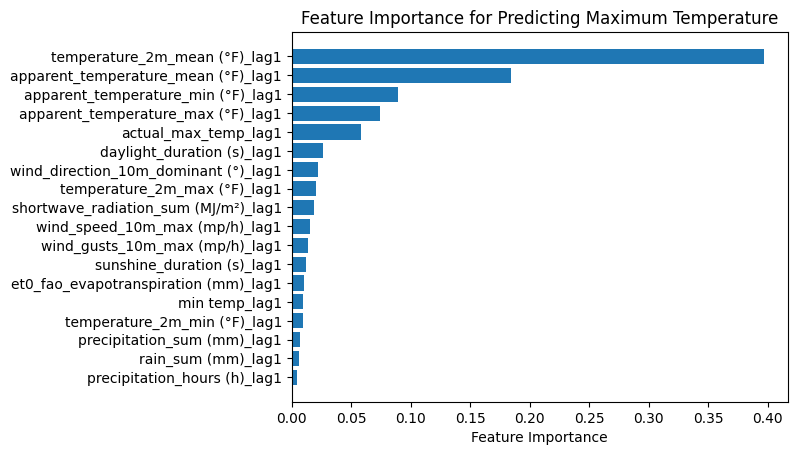

,Feature,Importance
4,temperature_2m_mean (°F)_lag1,0.396873
15,apparent_temperature_mean (°F)_lag1,0.184485
16,apparent_temperature_min (°F)_lag1,0.089342
17,apparent_temperature_max (°F)_lag1,0.073882
0,actual_max_temp_lag1,0.057896
5,daylight_duration (s)_lag1,0.026088
12,wind_direction_10m_dominant (°)_lag1,0.021763
18,wind_direction_10m_dominant (°)_lag1,0.021612
2,temperature_2m_max (°F)_lag1,0.020215
13,shortwave_radiation_sum (MJ/m²)_lag1,0.018652


In [11]:
rf.find_important_features(newdf, feature_columns, target)

## Create Train Test sets

In [12]:
X = newdf[feature_columns]
y = newdf[target]


X_train, y_train, X_test, y_test = hp.create_train_test(X, y, .6)
all_predictions = pd.DataFrame()

## Testing the performance of the Random Forest model

In [13]:
# grid search
best_model = rf.find_best_random_forest_model(X_train, y_train)

# get predictions
predictions = rf.get_rf_predictions(best_model, X_test)

# Calculate errors
hp.calculate_metrics(y_test, predictions)

Best parameters found:  {'bootstrap': True, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
Best cross-validation score:  0.8241267627454333
Mean Squared Error (MSE): 7.494078717145747
Mean Absolute Error (MAE): 1.9017412159825213
Root Mean Squared Error (RMSE): 2.7375315006672976


(7.494078717145747, 2.7375315006672976, 1.9017412159825213)

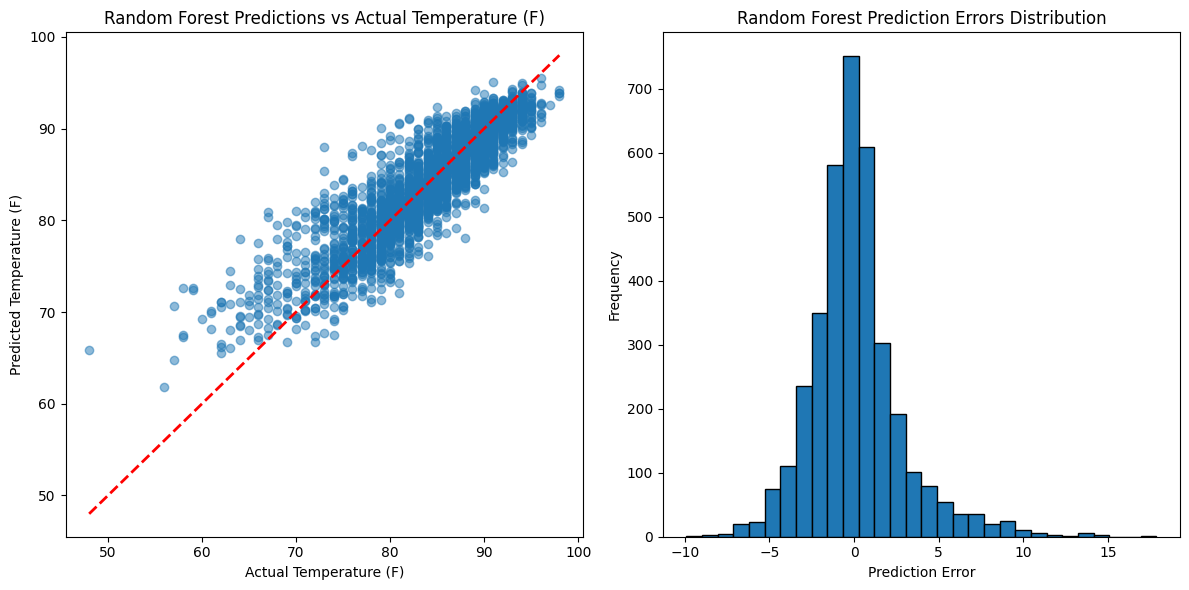

Mean Squared Error (MSE): 7.494078717145747
Mean Absolute Error (MAE): 1.9017412159825213
Root Mean Squared Error (RMSE): 2.7375315006672976


In [14]:
rf.plot_predictions(predictions, y_test)


### Implement LSTM and BiLSTM models

Epoch 1/50


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


69/69 - 2s - 30ms/step - loss: 0.6435 - val_loss: 0.2418
Epoch 2/50


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_accuracy available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


69/69 - 0s - 7ms/step - loss: 0.2919 - val_loss: 0.2249
Epoch 3/50
69/69 - 0s - 6ms/step - loss: 0.2555 - val_loss: 0.2053
Epoch 4/50
69/69 - 0s - 6ms/step - loss: 0.2407 - val_loss: 0.2015
Epoch 5/50
69/69 - 0s - 6ms/step - loss: 0.2307 - val_loss: 0.2015
Epoch 6/50
69/69 - 0s - 6ms/step - loss: 0.2350 - val_loss: 0.1942
Epoch 7/50
69/69 - 0s - 6ms/step - loss: 0.2274 - val_loss: 0.1906
Epoch 8/50
69/69 - 0s - 6ms/step - loss: 0.2175 - val_loss: 0.1906
Epoch 9/50
69/69 - 0s - 6ms/step - loss: 0.2187 - val_loss: 0.1887
Epoch 10/50
69/69 - 0s - 6ms/step - loss: 0.2166 - val_loss: 0.1892
Epoch 11/50
69/69 - 0s - 6ms/step - loss: 0.2050 - val_loss: 0.1901
Epoch 12/50
69/69 - 0s - 7ms/step - loss: 0.2038 - val_loss: 0.1897
Epoch 13/50
69/69 - 0s - 6ms/step - loss: 0.2028 - val_loss: 0.1858
Epoch 14/50
69/69 - 0s - 6ms/step - loss: 0.1956 - val_loss: 0.1857
Epoch 15/50
69/69 - 0s - 6ms/step - loss: 0.1994 - val_loss: 0.1851
Epoch 16/50
69/69 - 0s - 6ms/step - loss: 0.1877 - val_loss: 0.1890

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 7, 60)          │        12,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 7, 40)          │        12,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 20)             │         4,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         1,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 97,493 (380.84 KB)

 Trainable params: 32,497 (126.94 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 64,996 (253.89 KB)

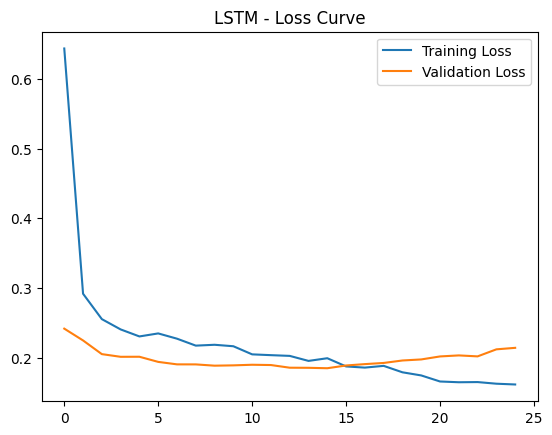

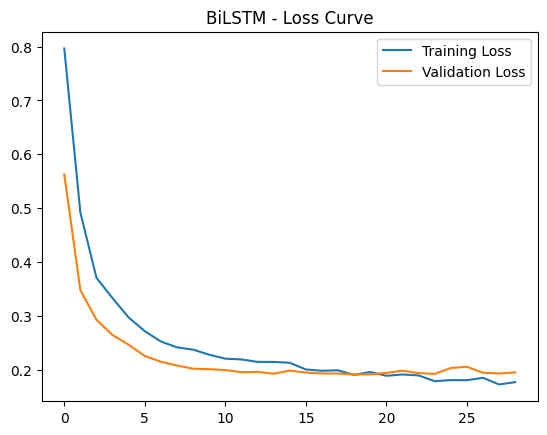

In [15]:
window = 7
X_windowed, y_windowed, X_test_windowed, y_test_windowed, feature_scaler, target_scaler = lstm.prepare_data(X_train, y_train, X_test, y_test, window_size=window)

lstm_units = 64  
lstm_batch_size = 64
lstm_epochs = 50
lstm_history, LSTM_model_name, trained_lstm_model = lstm.train_LSTM(X_windowed, y_windowed, lstm_units, lstm_batch_size, lstm_epochs, 'best_lstm_checkpoint.keras', verbose=2, learning_rate = .0007)

bl_units = 64  
bl_batch_size = 64
bl_epochs = 50
bilstm_history, biLSTM_model_name, trained_bilstm_model = lstm.train_BiLSTM(X_windowed, y_windowed, bl_units, bl_batch_size, bl_epochs,'best_bilstm_checkpoint.keras', verbose=2, learning_rate = .0005)

# Model summary to check the architecture
trained_bilstm_model.summary()

# Plot loss curves
lstm.plot_loss(lstm_history, LSTM_model_name)
lstm.plot_loss(bilstm_history, biLSTM_model_name)

114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


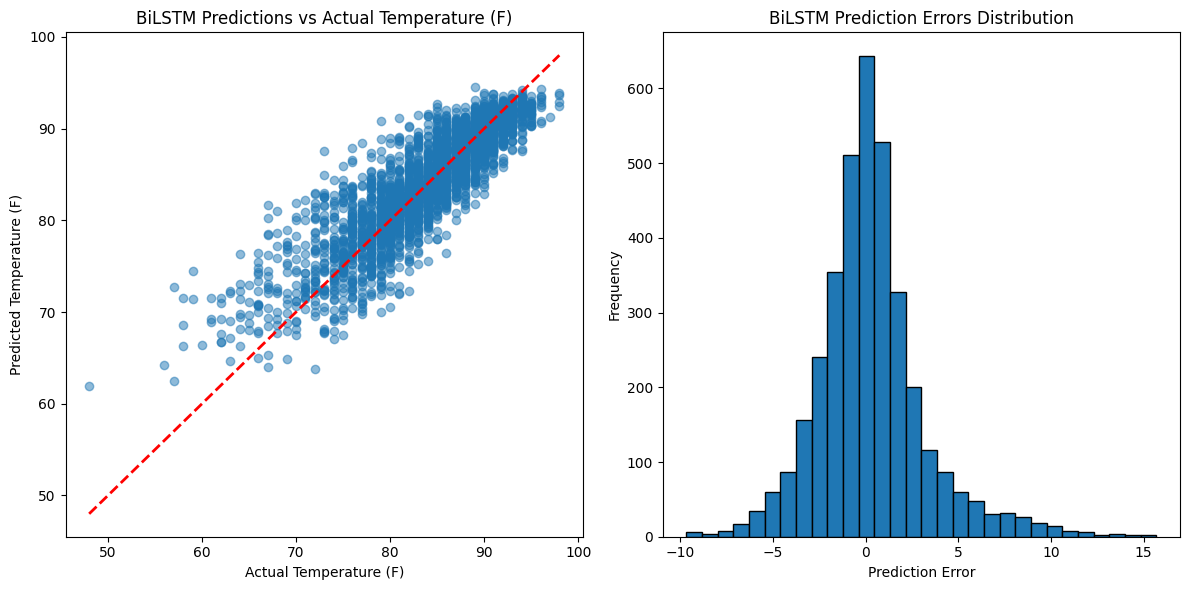

Mean Squared Error (MSE): 8.61094059064055
Mean Absolute Error (MAE): 2.05925286348201
Root Mean Squared Error (RMSE): 2.9344404220635574


In [16]:
bilstm_y_pred = lstm.get_predictions(trained_bilstm_model, X_test_windowed)

lstm.plot_predictions(biLSTM_model_name, X_test_windowed, y_test_windowed, bilstm_y_pred, target_scaler)

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


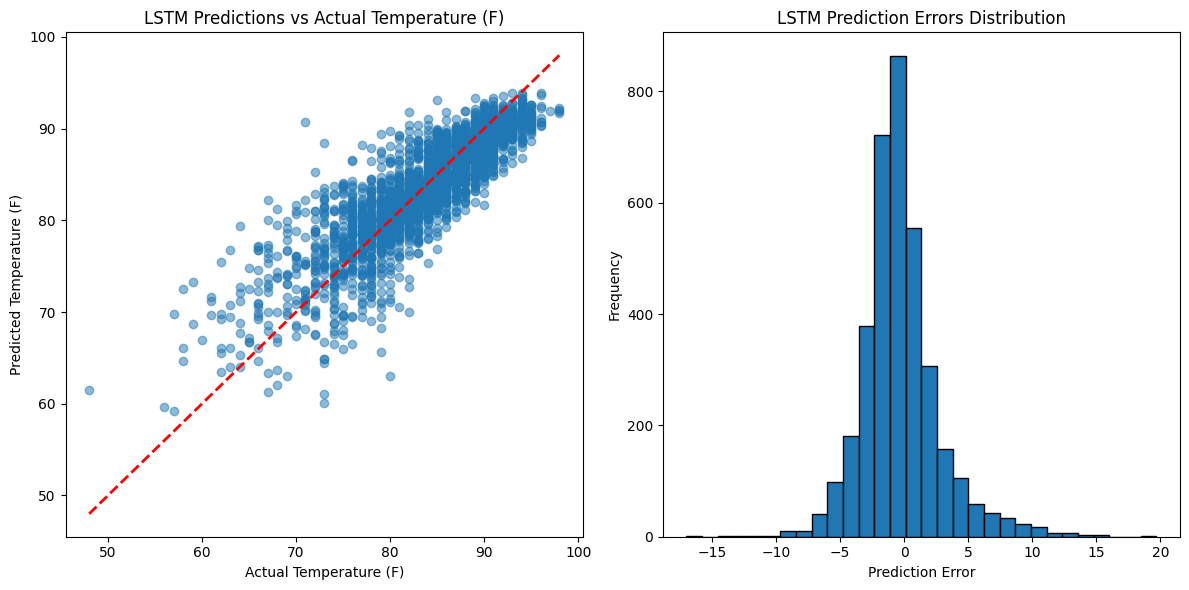

Mean Squared Error (MSE): 9.35865907595439
Mean Absolute Error (MAE): 2.1898246523434137
Root Mean Squared Error (RMSE): 3.059192552938502


In [17]:
lstm_y_pred = lstm.get_predictions(trained_lstm_model, X_test_windowed)
lstm.plot_predictions(LSTM_model_name, X_test_windowed, y_test_windowed, lstm_y_pred, target_scaler)

In [18]:

missing = window - 1
y_actual_test = y_test.iloc[missing:] #removes the first two observations since those are removed in the sliding window process.
rf_predictions = predictions[missing:]
predictions_df = pd.DataFrame(y_actual_test)
predictions_df['lstm_predictions'] = lstm_y_pred
predictions_df['bilstm_predictions'] = bilstm_y_pred
predictions_df['rf_predictions'] = rf_predictions

open_meteo_forecast = pd.read_csv("/Users/bram/Desktop/AI-class/semester-project-bram-long/Data/OpenMeteoMiamiForecast.csv")
open_meteo_forecast ['time'] = pd.to_datetime(open_meteo_forecast ['time'], format='%m/%d/%y')
open_meteo_forecast = open_meteo_forecast.set_index("time")
open_meteo_forecast = open_meteo_forecast.rename(columns={"temperature_2m_max (°F)":"open_meteo_forecast"})

prediction_merge = pd.merge(open_meteo_forecast, predictions_df, left_index=True, right_index=True)



In [19]:
actual = prediction_merge['actual_max_temp']
open_predicted = prediction_merge['open_meteo_forecast']


lstm_predictions_np = prediction_merge['lstm_predictions'].to_numpy()
lstm_predictions_np = target_scaler.inverse_transform(lstm_predictions_np.reshape(-1, 1))

bilstm_predictions_np = prediction_merge['bilstm_predictions'].to_numpy()
bilstm_predictions_np = target_scaler.inverse_transform(bilstm_predictions_np.reshape(-1, 1))


rf_metrics = hp.calculate_metrics(actual, prediction_merge['rf_predictions'])
lstm_metrics = hp.calculate_metrics(actual, lstm_predictions_np)
bilstm_metrics = hp.calculate_metrics(actual, bilstm_predictions_np)
open_metrics = hp.calculate_metrics(actual, open_predicted)



Mean Squared Error (MSE): 8.082738383230897
Mean Absolute Error (MAE): 2.0164076410381515
Root Mean Squared Error (RMSE): 2.843015719835347
Mean Squared Error (MSE): 9.82478848061924
Mean Absolute Error (MAE): 2.300366751866858
Root Mean Squared Error (RMSE): 3.1344518628652187
Mean Squared Error (MSE): 9.22985966486346
Mean Absolute Error (MAE): 2.174372173071458
Root Mean Squared Error (RMSE): 3.038068410168451
Mean Squared Error (MSE): 4.117020785219398
Mean Absolute Error (MAE): 1.6639722863741335
Root Mean Squared Error (RMSE): 2.029044303414639


In [20]:
y_ensemble = prediction_merge['actual_max_temp']

X_ensemble = prediction_merge[['open_meteo_forecast', 'lstm_predictions',
       'bilstm_predictions', 'rf_predictions']]
 
X_ensemble_train, y_ensemble_train, X_ensemble_test, y_ensemble_test = hp.create_train_test(X_ensemble ,y_ensemble, .7)

ensemble_X_windowed, ensemble_y_windowed, ensemble_X_test_windowed, ensemble_y_test_windowed, ensemble_feature_scaler, ensemble_target_scaler = lstm.prepare_data(X_ensemble_train, y_ensemble_train, X_ensemble_test, y_ensemble_test, window_size=7)

lstm_units = 64  
lstm_batch_size = 64
lstm_epochs = 300
ensemble_lstm_history, ensemble_LSTM_model_name, ensemble_trained_lstm_model = lstm.train_LSTM(ensemble_X_windowed, ensemble_y_windowed, lstm_units, lstm_batch_size, lstm_epochs, 'ensemble_lstm_checkpoint.keras', verbose=2, learning_rate = .0007)

bl_units = 64  
bl_batch_size = 64
bl_epochs = 300
ensemble_bilstm_history, ensemble_biLSTM_model_name, ensemble_trained_bilstm_model = lstm.train_BiLSTM(ensemble_X_windowed, ensemble_y_windowed, bl_units, bl_batch_size, bl_epochs, 'ensemble_bilstm_checkpoint.keras', verbose=2, learning_rate = .0005)



Epoch 1/300


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 - 1s - 357ms/step - loss: 0.9804 - val_loss: 1.1055
Epoch 2/300
4/4 - 0s - 11ms/step - loss: 0.9695 - val_loss: 1.0921
Epoch 3/300
4/4 - 0s - 10ms/step - loss: 0.9574 - val_loss: 1.0715
Epoch 4/300
4/4 - 0s - 11ms/step - loss: 0.9497 - val_loss: 1.0408
Epoch 5/300
4/4 - 0s - 11ms/step - loss: 0.9151 - val_loss: 0.9990
Epoch 6/300


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_accuracy available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


4/4 - 0s - 11ms/step - loss: 0.8725 - val_loss: 0.9230
Epoch 7/300
4/4 - 0s - 11ms/step - loss: 0.8146 - val_loss: 0.8045
Epoch 8/300
4/4 - 0s - 10ms/step - loss: 0.6773 - val_loss: 0.6247
Epoch 9/300
4/4 - 0s - 10ms/step - loss: 0.4966 - val_loss: 0.4743
Epoch 10/300
4/4 - 0s - 10ms/step - loss: 0.4820 - val_loss: 0.3830
Epoch 11/300
4/4 - 0s - 10ms/step - loss: 0.4043 - val_loss: 0.3597
Epoch 12/300
4/4 - 0s - 10ms/step - loss: 0.3445 - val_loss: 0.3272
Epoch 13/300
4/4 - 0s - 10ms/step - loss: 0.3079 - val_loss: 0.3085
Epoch 14/300
4/4 - 0s - 10ms/step - loss: 0.2948 - val_loss: 0.3002
Epoch 15/300
4/4 - 0s - 10ms/step - loss: 0.2781 - val_loss: 0.2644
Epoch 16/300
4/4 - 0s - 10ms/step - loss: 0.2443 - val_loss: 0.2430
Epoch 17/300
4/4 - 0s - 10ms/step - loss: 0.2303 - val_loss: 0.2205
Epoch 18/300
4/4 - 0s - 11ms/step - loss: 0.2046 - val_loss: 0.1970
Epoch 19/300
4/4 - 0s - 10ms/step - loss: 0.2348 - val_loss: 0.1891
Epoch 20/300
4/4 - 0s - 10ms/step - loss: 0.2032 - val_loss: 0.1

In [35]:
ensemble_trained_lstm_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 7, 64)          │        17,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 174,053 (679.90 KB)

 Trainable params: 58,017 (226.63 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 116,036 (453.27 KB)

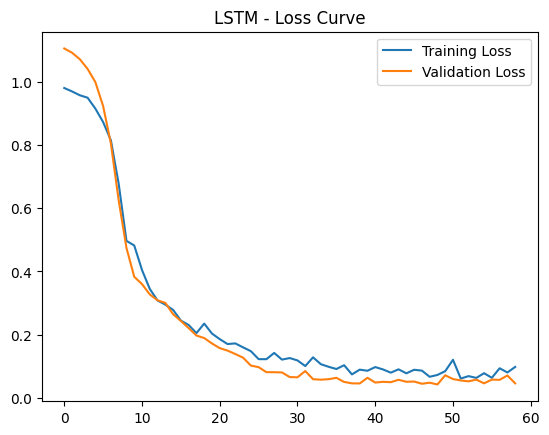

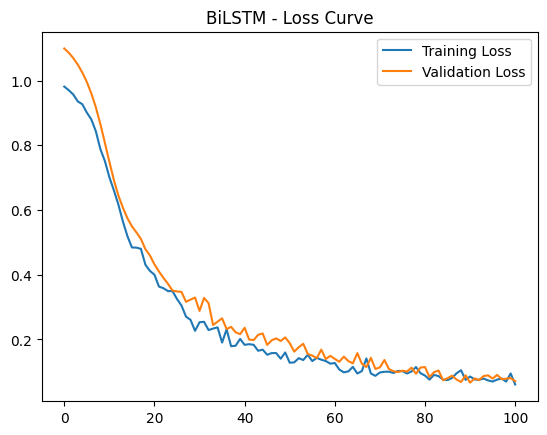

In [26]:

lstm.plot_loss(ensemble_lstm_history, ensemble_LSTM_model_name)
lstm.plot_loss(ensemble_bilstm_history, ensemble_biLSTM_model_name)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


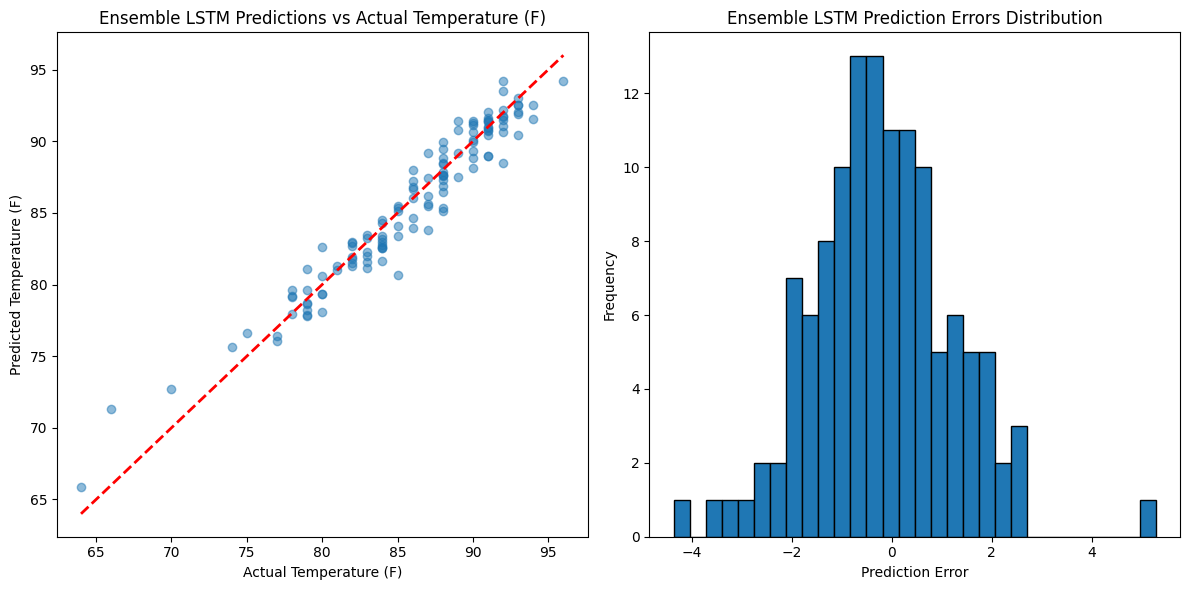

Mean Squared Error (MSE): 2.0592018045835205
Mean Absolute Error (MAE): 1.1138350579046434
Root Mean Squared Error (RMSE): 1.4349919179505928


In [27]:
ensemble_lstm_y_pred = lstm.get_predictions(ensemble_trained_lstm_model, ensemble_X_test_windowed)

lstm.plot_predictions('Ensemble LSTM', ensemble_X_test_windowed, ensemble_y_test_windowed, ensemble_lstm_y_pred, ensemble_target_scaler)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


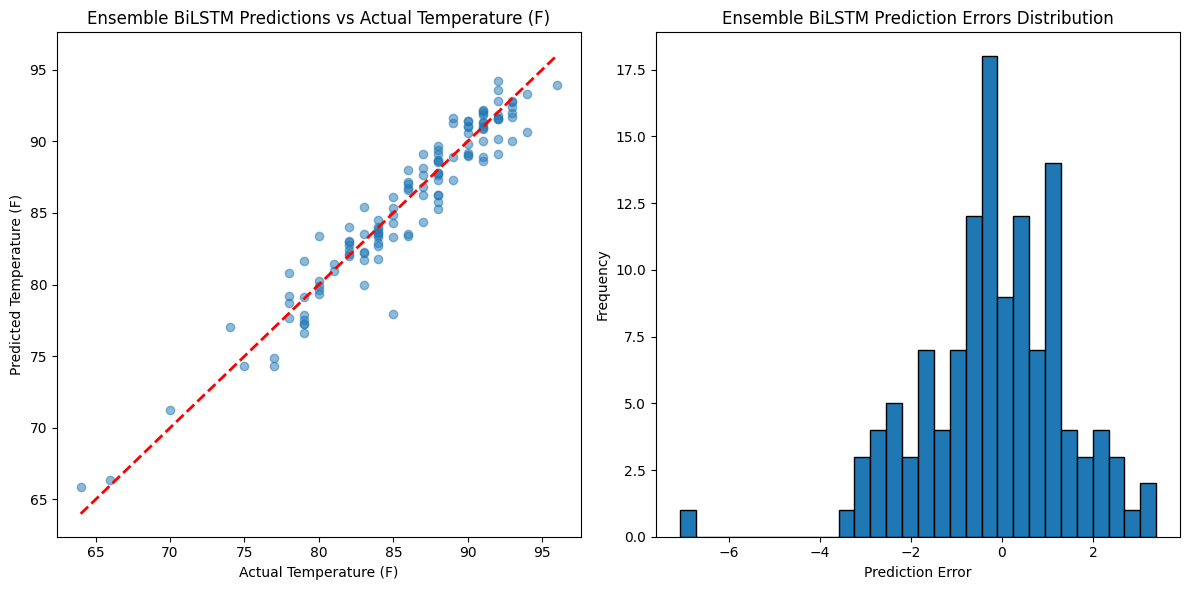

Mean Squared Error (MSE): 2.4946938481030707
Mean Absolute Error (MAE): 1.2022987488777406
Root Mean Squared Error (RMSE): 1.5794599862304428


In [28]:
ensemble_bilstm_y_pred = lstm.get_predictions(ensemble_trained_bilstm_model, ensemble_X_test_windowed)

lstm.plot_predictions('Ensemble BiLSTM', ensemble_X_test_windowed, ensemble_y_test_windowed, ensemble_bilstm_y_pred, ensemble_target_scaler)


# print(target_scaler.inverse_transform(ensemble_y_test_windowed))

In [29]:
# grid search
ensemble_rf_best_model = rf.find_best_random_forest_model(X_ensemble_train, y_ensemble_train)

# get predictions
ensemble_rf_predictions = rf.get_rf_predictions(ensemble_rf_best_model, X_ensemble_test)

hp.calculate_metrics(y_ensemble_test, ensemble_rf_predictions)



Best parameters found:  {'bootstrap': True, 'max_depth': 20, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation score:  0.9442597449806831
Mean Squared Error (MSE): 1.7335980469656695
Mean Absolute Error (MAE): 1.0287669108669106
Root Mean Squared Error (RMSE): 1.316661705589431


(1.7335980469656695, 1.316661705589431, 1.0287669108669106)

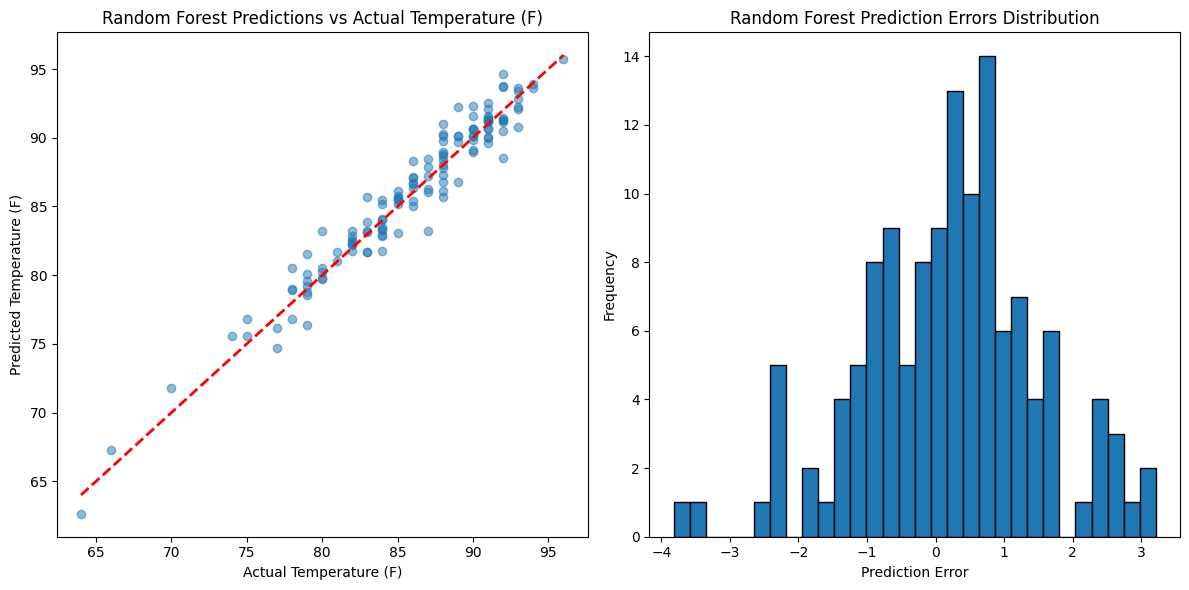

Mean Squared Error (MSE): 1.7335980469656695
Mean Absolute Error (MAE): 1.0287669108669106
Root Mean Squared Error (RMSE): 1.316661705589431


2024-11-06    86.0
2022-06-27    90.0
2023-02-04    75.0
2022-03-18    85.0
2024-07-06    91.0
              ... 
2024-09-02    90.0
2022-09-03    93.0
2022-08-21    93.0
2024-11-24    78.0
2024-09-19    89.0
Name: actual_max_temp, Length: 130, dtype: float64

In [ ]:
rf.plot_predictions(ensemble_rf_predictions, y_ensemble_test)

In [ ]:

open_m_test = X_ensemble_test['open_meteo_forecast']

hp.calculate_metrics(y_ensemble_test, open_m_test )

Mean Squared Error (MSE): 3.8598461538461537
Mean Absolute Error (MAE): 1.575384615384615
Root Mean Squared Error (RMSE): 1.9646491172334448


(3.8598461538461537, 1.9646491172334448, 1.575384615384615)

In [44]:
rf_residuals = y_ensemble_test - ensemble_rf_predictions

std_rf_residuals = np.std(rf_residuals)
print(std_rf_residuals)


ensemble_y_test_windowed_s = ensemble_target_scaler.inverse_transform(ensemble_y_test_windowed)

lstm_residuals = ensemble_y_test_windowed_s - ensemble_target_scaler.inverse_transform(ensemble_lstm_y_pred)

std_lstm_residuals= np.std(lstm_residuals)
std_lstm_residuals

1.303548145032748


1.4206195782322548